# Example 1: fitting $\mu, \sigma - SNR$ relation, and initializing

In seal, prior distribution of $A_{ij}$ is SNR-dependent: 

$p(A_{ij}) \propto N(-\mu, \sigma^2) + N(\mu, \sigma^2)$

where $N$ is Gaussian distribution and $\mu, \sigma$ are SNR-dependent coefficients. SNR, on the other hand, is dependent on detector configuration. The relation should be pre-trained before localization. We found an useful approximation of this relation for all PSD and detector network:

$\mu = a*SNR + b$, and $\sigma = c*SNR + d$.

This script shows how to get $a,b,c,d$ for your configuration (detector network and PSD), and store it for next-time use.

The interface of seal is the class "Seal", it contains the basic properties of our localization method: $a,b,c,d$. With these coefficients you can localize GW event (see next examples). However if $a,b,c,d$ are not given, we need to fit them before localization. The fitting only need to be done once as long as your configuration is not chenged.

Before localization, you need also to initialized the Seal. If it is trained just now then it is already initialized. Otherwise, we need to read from a file you stored or manually initialized it.

In [1]:
import bilby
import numpy as np 
import time
import sys
import matplotlib.pyplot as plt
from multiprocessing import Pool
import multiprocessing
from functools import partial
from matplotlib.pyplot import MultipleLocator
from bilby.gw import conversion
from scipy.optimize import leastsq
import json

import sealgw
import sealgw.simulation as sealsim
from sealgw import seal

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Fitting with bilby default PSDs (design sensitivity)

If you are doing injection with bilby, then bilby itself stores some PSDs. Here we use its L+H+V network.

In [2]:
# Set a seal, it is not initialized yet.
seal_bilby_design_lhv = seal.Seal()

print(seal_bilby_design_lhv.initialized)
print(seal_bilby_design_lhv.description)

False
An uninitialized seal.


In [3]:
# Now fit the relation. 
# Use "seal_bilby_design_lhv.fitting_mu_sigma_snr_relation?" to see what parameters you can set.

Nsample = 10000
det_name_list = ['L1', 'H1', 'V1']
source_type = "BNS"
ncpu = 6
low_snr_cutoff = 9
high_snr_cutoff = 35
plotsave = ['example_outputs/linear_fitting.png', 'example_outputs/bimodal_fitting.png'] 
fitting_samples = seal_bilby_design_lhv.fitting_mu_sigma_snr_relation(Nsample=Nsample, det_name_list=det_name_list, source_type=source_type, ncpu=ncpu,
                                                                     low_snr_cutoff=low_snr_cutoff,high_snr_cutoff=high_snr_cutoff)



16:22 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_neutron_star
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_neutron_star_parameters


<Figure size 432x288 with 0 Axes>

True


<Figure size 432x288 with 0 Axes>

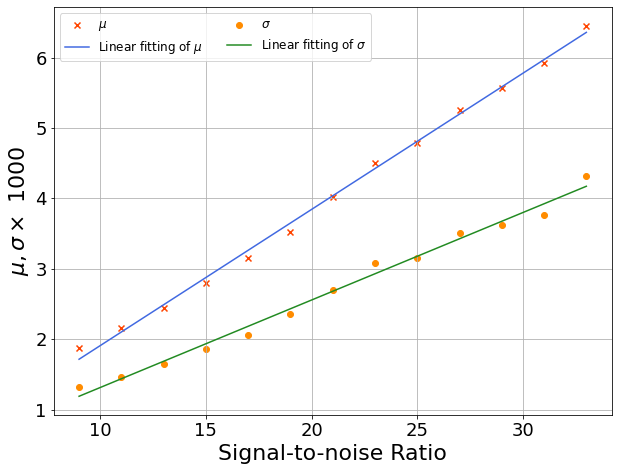

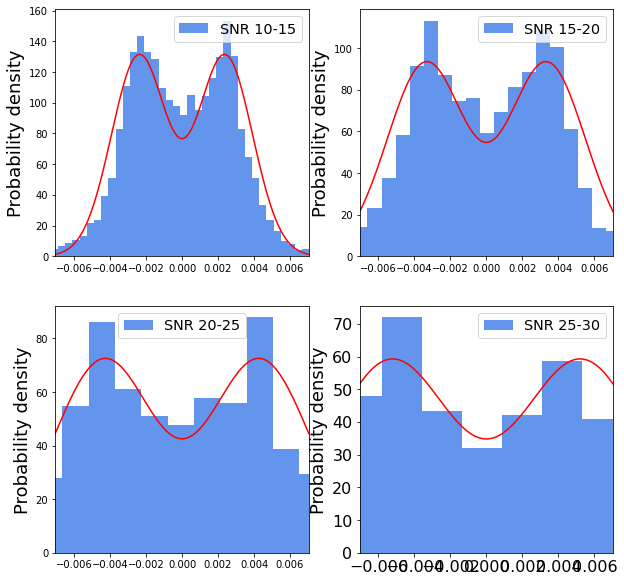

In [4]:
# examine it
snr_steps = np.arange(low_snr_cutoff, high_snr_cutoff ,2)

a,b,c,d,mu_list,sigma_list = sealsim.prior_fitting.fitting_abcd(fitting_samples, snr_steps,source_type)
print(a==seal_bilby_design_lhv.prior_coef_a)

fig = sealsim.prior_fitting.linear_fitting_plot(snr_steps, mu_list, sigma_list, a, b, c, d, plotsave[0])
fig = sealsim.prior_fitting.bimodal_fitting_plot(fitting_samples, a, b, c, d,
                                          [10,15,20,25], [15,20,25,30], save_filename=plotsave[1])


Done! It takes ~1min on my laptop, using 6 cpus.

In general, I recommend Nsample>30000 for an accurate fitting, it won't take too long anyway.

The two plots are saved to the path we set.

You can access these coefficients by:


In [5]:
print(seal_bilby_design_lhv.prior_coef_a)
print(seal_bilby_design_lhv.description)
print(seal_bilby_design_lhv.initialized)
# You can see it's now initialized.

0.00019341326656917662
Seal trained with bilby PSD for L1 H1 V1 
True


# Fitting with your own PSD

You may want to fit with PSDs that are not stored in bilby: simply disable bilby PSD and set your own PSD path.

The psd file should be plain text, with 2 colunms. 1st for frequency, 2nd for PSD (not ASD). 

In [6]:
seal_O2_lhv = seal.Seal()

Nsample = 10000
det_name_list = ['L1', 'H1', 'V1']
# psd files should be the same squence as in det_name_list
psd_files = ['example_inputs/L1_psd.txt','example_inputs/H1_psd.txt','example_inputs/V1_psd.txt']

source_type = "BNS"
ncpu = 6
plotsave = ['example_outputs/linear_fitting_custom.png', 'example_outputs/bimodal_fitting_custom.png'] 
low_snr_cutoff = 9
high_snr_cutoff = 31
fitting_samples = seal_O2_lhv.fitting_mu_sigma_snr_relation(Nsample=Nsample, det_name_list=det_name_list, source_type=source_type, ncpu=ncpu,
                                          use_bilby_psd = False, custom_psd_path = psd_files,
                                          low_snr_cutoff=low_snr_cutoff,high_snr_cutoff=high_snr_cutoff)

16:23 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_neutron_star
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_neutron_star_parameters


<Figure size 432x288 with 0 Axes>

True


<Figure size 432x288 with 0 Axes>

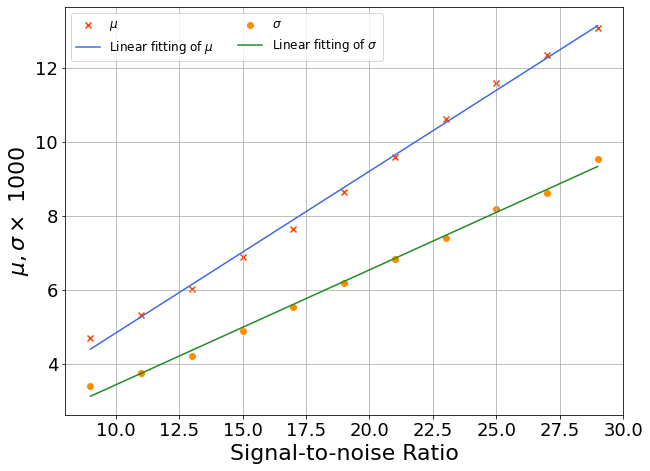

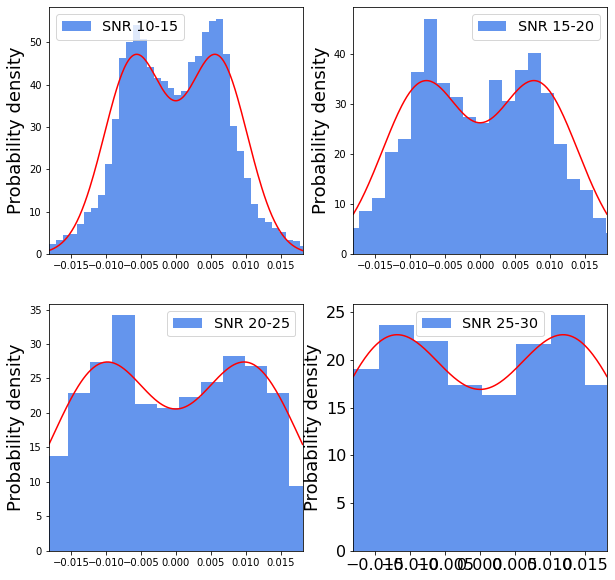

In [7]:
# examine it
snr_steps = np.arange(low_snr_cutoff, high_snr_cutoff ,2)

a,b,c,d,mu_list,sigma_list = sealsim.prior_fitting.fitting_abcd(fitting_samples, snr_steps,source_type)
print(a==seal_O2_lhv.prior_coef_a)

fig = sealsim.prior_fitting.linear_fitting_plot(snr_steps, mu_list, sigma_list, a, b, c, d, plotsave[0])
fig = sealsim.prior_fitting.bimodal_fitting_plot(fitting_samples, a, b, c, d,
                                          [10,15,20,25], [15,20,25,30], save_filename=plotsave[1])


##### For more convenient fitting with PSDs in xml file, see scripts_for_spiir/pre_fitting. 

This will store a config file that contains all source types!

# Storing and loading your fitting result

The fitting result can be saved as a file and be read when you use it, so that you don't need to copy $a,b,c,d$ to your code and manually initialize the seal (you can do this if you prefer, as I will show in the end).

Note: you can change .txt to .json if you want. 

In [8]:
# Store the seal you just fit
seal_bilby_design_lhv.save_config_dict('example_outputs/sealconfig_bilby_lhv_BNS.txt')
seal_O2_lhv.save_config_dict('example_outputs/sealconfig_O2_lhv_BNS.txt')

In [9]:
# Next time you can read it
seal_new = seal.Seal(config_dict="example_outputs/sealconfig_O2_lhv_BNS.txt")

print(seal_new.prior_coef_a)
print(seal_new.description)
print(seal_new.initialized)


0.0004378621243075729
Seal trained with own PSD for L1 H1 V1 
True


In [10]:
# If config dict contains more than one source types, you need to specify source type for your seal.
# For example:
seal_new1 = seal.Seal(config_dict="../scripts/spiir/seal_training_outputs/config_LHV_O4ExpectedPSD.json", source_type='BNS')
print(seal_new1.description)

seal_new2 = seal.Seal(config_dict="../scripts/spiir/seal_training_outputs/config_LHV_O4ExpectedPSD.json", source_type='BBH')
print(seal_new2.description)

seal_new3 = seal.Seal(config_dict="../scripts/spiir/seal_training_outputs/config_LHV_O4ExpectedPSD.json", source_type='NSBH')
print(seal_new3.description)

Config file for BNS LHV_O4ExpectedPSD
Config file for BBH LHV_O4ExpectedPSD
Config file for NSBH LHV_O4ExpectedPSD


In [11]:
# They can be saved by
seal_list = [seal_new1, seal_new2, seal_new3]
source_types = ['BNS', 'BBH', 'NSBH']
label = 'LHV_O4ExpectedPSD'
outputfilename = 'example_outputs/config_multiple_saving_example.json'  # or txt
sealsim.prior_fitting.save_configs(source_types, label, seal_list, outputfilename)

# Manually initialize seal

Alternatively you can note the coefficients somewhere, write a dictionary and manually intialized your seal

In [12]:
config_dict = {'description': "my seal with xxx config",
              'a': 1,
              'b': 1,
              'c': 1,
              'd': 1,} # These coefficients are not realistic

seal_manually_initialized = seal.Seal(config_dict=config_dict)

In [13]:
print(seal_manually_initialized.initialized)
print(seal_manually_initialized.description)
print(seal_manually_initialized.prior_coef_a)


True
my seal with xxx config
1


# BBH fitting

Empirically prior for BNS works fine for BBH events, this happened when we used GW170817's prior for GW170814 (see Chichi's post on SPIIR wiki). I guess the result is not that sensitive to prior coefficients...

Fitting BBH's prior is not as easy as that of BNS, because BBH's intrinsic parameter can vary in a larger range. The result would be highly dependent on the BBH's intrinsic parameters settings in our simulation. (By contrast, BNS's masses are contrained in a narrow range.)

Here is an example for BBH fitting. Although coefficients are not that important, it's better to have an independent version for BBH.

In [14]:
# Set a seal, it is not initialized yet.
seal_bilby_design_lhv_BBH = seal.Seal()

print(seal_bilby_design_lhv_BBH.initialized)
print(seal_bilby_design_lhv_BBH.description)

False
An uninitialized seal.


In [15]:
# Now fit the relation. 
# Use "seal_bilby_design_lhv.fitting_mu_sigma_snr_relation?" to see what parameters you can set.

Nsample = 10000
det_name_list = ['L1', 'H1', 'V1']
source_type = "BBH"
ncpu = 6
low_snr_cutoff = 9
high_snr_cutoff = 41
fitting_samples = seal_bilby_design_lhv_BBH.fitting_mu_sigma_snr_relation(Nsample=Nsample, det_name_list=det_name_list, source_type=source_type, ncpu=ncpu,
                                                                     low_snr_cutoff=low_snr_cutoff,high_snr_cutoff=high_snr_cutoff)



16:24 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


<Figure size 432x288 with 0 Axes>

True


<Figure size 432x288 with 0 Axes>

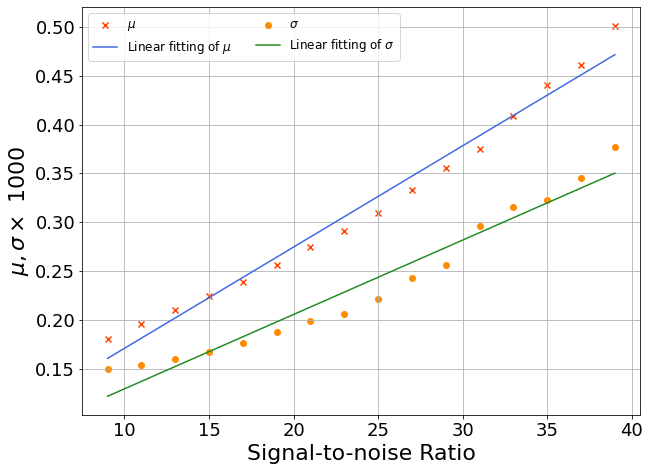

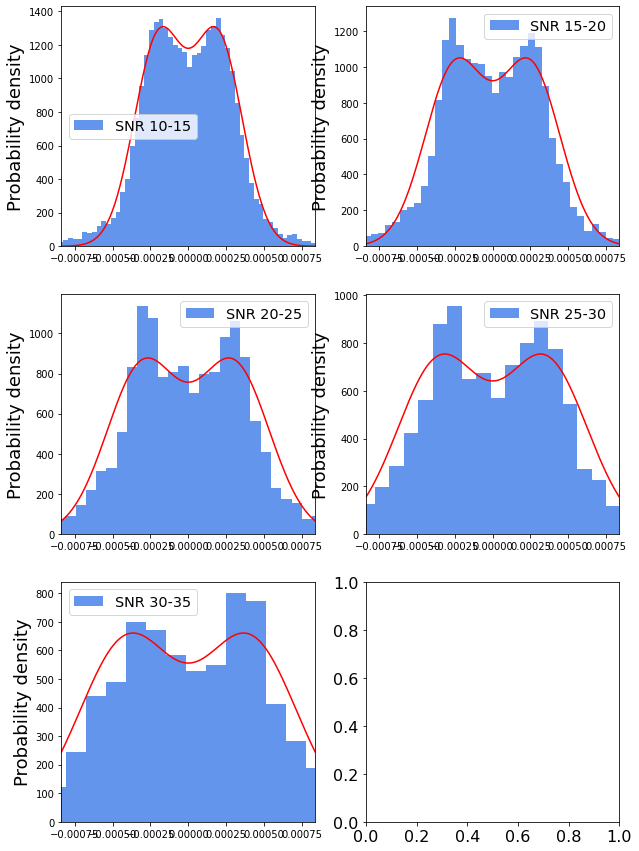

In [16]:
# examine it
snr_steps = np.arange(low_snr_cutoff, high_snr_cutoff ,2)

a,b,c,d,mu_list,sigma_list = sealsim.prior_fitting.fitting_abcd(fitting_samples, snr_steps,source_type)
print(a==seal_bilby_design_lhv_BBH.prior_coef_a)

fig = sealsim.prior_fitting.linear_fitting_plot(snr_steps, mu_list, sigma_list, a, b, c, d)
fig = sealsim.prior_fitting.bimodal_fitting_plot(fitting_samples, a, b, c, d,
                                          [10,15,20,25,30], [15,20,25,30,35])


We can see that the differences between BNS and BBH are:

1. Aij are smaller. 0.01 for BNS while 0.0005 for BBH.

2. (As a result of 1) mu and sigma, as well as a,b,c,d are smaller.

In [17]:
seal_bilby_design_lhv_BBH.description = 'BBH for LHV design sensitivities.'
seal_bilby_design_lhv_BBH.save_config_dict('example_outputs/sealconfig_bilby_lhv_BBH.txt')

# NSBH fitting

Similar to BBH

In [18]:
# Set a seal, it is not initialized yet.
seal_bilby_design_lhv_NSBH = seal.Seal()

print(seal_bilby_design_lhv_NSBH.initialized)
print(seal_bilby_design_lhv_NSBH.description)

False
An uninitialized seal.


In [19]:
# Now fit the relation. 
# Use "seal_bilby_design_lhv.fitting_mu_sigma_snr_relation?" to see what parameters you can set.

Nsample = 10000
det_name_list = ['L1', 'H1', 'V1']
source_type = "NSBH"
ncpu = 6
low_snr_cutoff = 9
high_snr_cutoff = 31
fitting_samples = seal_bilby_design_lhv_NSBH.fitting_mu_sigma_snr_relation(Nsample=Nsample, det_name_list=det_name_list, source_type=source_type, ncpu=ncpu,
                                                                     low_snr_cutoff=low_snr_cutoff,high_snr_cutoff=high_snr_cutoff)



16:26 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_neutron_star
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


<Figure size 432x288 with 0 Axes>

True


<Figure size 432x288 with 0 Axes>

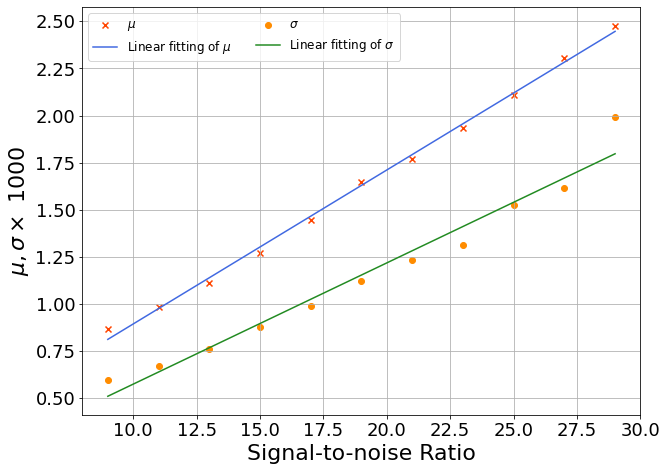

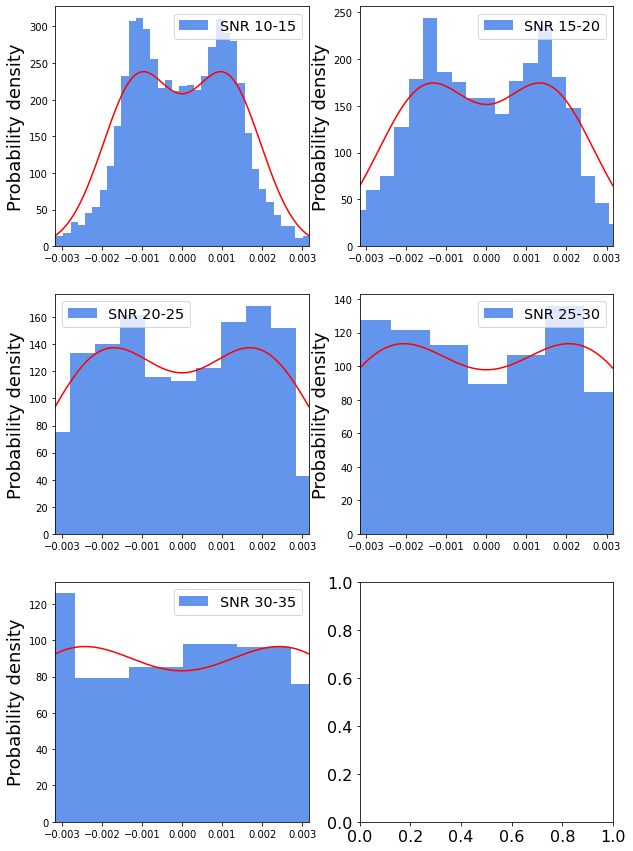

In [20]:
# examine it
snr_steps = np.arange(low_snr_cutoff, high_snr_cutoff ,2)

a,b,c,d,mu_list,sigma_list = sealsim.prior_fitting.fitting_abcd(fitting_samples, snr_steps,source_type)
print(a==seal_bilby_design_lhv_NSBH.prior_coef_a)

fig = sealsim.prior_fitting.linear_fitting_plot(snr_steps, mu_list, sigma_list, a, b, c, d)
fig = sealsim.prior_fitting.bimodal_fitting_plot(fitting_samples, a, b, c, d,
                                          [10,15,20,25,30], [15,20,25,30,35])


In [21]:
seal_bilby_design_lhv_NSBH.description = 'NSBH for LHV design sensitivities.'
seal_bilby_design_lhv_NSBH.save_config_dict('example_outputs/sealconfig_bilby_lhv_NSBH.txt')